In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn as sk
import statsmodels as smf
from datetime import datetime

## Importing the datasets

In [2]:
store = pd.read_csv('C:/users/HP/Downloads/2. Walmart Store Sales Forecasting/data/stores.csv')
ft = pd.read_csv('C:/users/HP/Downloads/2. Walmart Store Sales Forecasting/data/features.csv')
train = pd.read_csv('C:/users/HP/Downloads/2. Walmart Store Sales Forecasting/data/train.csv')
test = pd.read_csv('C:/users/HP/Downloads/2. Walmart Store Sales Forecasting/data/test.csv')

## Merging the datasets

In [3]:
train_bt = pd.merge(train,store) 
train = pd.merge(train_bt,ft)

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
Store        115064 non-null int64
Dept         115064 non-null int64
Date         115064 non-null object
IsHoliday    115064 non-null bool
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [5]:
test_bt = pd.merge(test,store)
test= pd.merge(test_bt,ft)

## Defining the UDFs

In [6]:
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [7]:
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

## Data Sorting

In [8]:
#Selecting Only the positive Sales

train = train[train['Weekly_Sales']>0]

In [9]:
train_num = train.select_dtypes(['int32' , 'float32' , 'int64' , 'float64'])

In [10]:
train_num = train_num.apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), upper = x.quantile(0.99)))

In [11]:
train_num_summ = train_num.apply(continuous_var_summary)

In [12]:
train_num_summ

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
N,4.202120e+05,4.202120e+05,4.202120e+05,4.202120e+05,4.202120e+05,4.202120e+05,1.501810e+05,1.109040e+05,1.366510e+05,1.345180e+05,1.509290e+05,4.202120e+05,4.202120e+05
NMISS,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.700310e+05,3.093080e+05,2.835610e+05,2.856940e+05,2.692830e+05,0.000000e+00,0.000000e+00
SUM,9.326862e+06,1.858988e+07,6.599850e+09,5.746388e+10,2.525834e+07,1.411967e+06,1.066650e+09,3.484310e+08,1.687385e+08,4.396315e+08,6.712092e+08,7.194284e+07,3.344754e+06
MEAN,2.219561e+01,4.423928e+01,1.570600e+04,1.367497e+05,6.010855e+01,3.360130e+00,7.102432e+03,3.141735e+03,1.234814e+03,3.268198e+03,4.447185e+03,1.712060e+02,7.959682e+00
MEDIAN,2.200000e+01,3.700000e+01,7.661700e+03,1.401670e+05,6.209000e+01,3.452000e+00,5.347450e+03,1.920000e+02,2.460000e+01,1.481310e+03,3.359450e+03,1.823510e+02,7.866000e+00
STD,1.278724e+01,3.050521e+01,2.079992e+04,6.099308e+04,1.829728e+01,4.562112e-01,7.423264e+03,8.050646e+03,7.704015e+03,5.488764e+03,4.233540e+03,3.915281e+01,1.859997e+00
VAR,1.635134e+02,9.305678e+02,4.326367e+08,3.720156e+09,3.347906e+02,2.081287e-01,5.510485e+07,6.481290e+07,5.935185e+07,3.012653e+07,1.792286e+07,1.532942e+03,3.459587e+00
MIN,1.000000e+00,1.000000e+00,7.440000e+00,3.487500e+04,1.830000e+01,2.565000e+00,1.776000e+01,-9.900000e-01,6.000000e-02,3.970000e+00,3.519700e+02,1.261119e+02,4.156000e+00
P1,1.000000e+00,1.000000e+00,7.440000e+00,3.487500e+04,1.830000e+01,2.565000e+00,1.776000e+01,-9.900000e-01,6.000000e-02,3.970000e+00,3.519700e+02,1.261119e+02,4.156000e+00
P5,3.000000e+00,4.000000e+00,6.755100e+01,3.969000e+04,2.731000e+01,2.653000e+00,1.491900e+02,1.950000e+00,6.500000e-01,2.876000e+01,7.155200e+02,1.264963e+02,5.326000e+00


In [13]:
train_cat = train.select_dtypes('object')

In [14]:
train_cat_summ = train_cat.apply(categorical_var_summary)

In [15]:
train_cat_summ

,Date,Type
N,420212,420212
NMISS,0,0
MODE,2011-12-23,A
FREQ,3018,214961
PERCENT,0.72,51.16


## Missing Values Treatment

In [16]:
print (train.isnull().sum())
print ("******************")
print (test.isnull().sum())

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270031
MarkDown2       309308
MarkDown3       283561
MarkDown4       285694
MarkDown5       269283
CPI                  0
Unemployment         0
dtype: int64
******************
Store               0
Dept                0
Date                0
IsHoliday           0
Type                0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
dtype: int64


In [17]:
test.CPI.fillna(np.mean(test.CPI) , inplace=True)
train.CPI.fillna(np.mean(train.CPI) , inplace=True)
test.Unemployment.fillna(np.mean(test.Unemployment) , inplace=True)
train.Unemployment.fillna(np.mean(train.Unemployment) , inplace=True)

In [18]:
#Missing Values in Markdowns, imputing with 0

train = train.fillna(0)
test = test.fillna(0)

## Outlier Treatment

In [19]:
train.Weekly_Sales = np.where(train.Weekly_Sales > 10000 , 10000 , train.Weekly_Sales)

## Data Featuring

In [20]:
train['Date'] = pd.to_datetime(train['Date'])

test['Date'] = pd.to_datetime(test['Date'])

In [22]:
train['Date_dayofweek'] = train['Date'].dt.dayofweek

train['Date_month'] = train['Date'].dt.month 

train['Date_year'] = train['Date'].dt.year

train['Date_day'] = train['Date'].dt.day

In [23]:
test['Date_dayofweek'] = test['Date'].dt.dayofweek

test['Date_month'] = test['Date'].dt.month 

test['Date_year'] = test['Date'].dt.year

test['Date_day'] = test['Date'].dt.day

## Converting Catergorical Variables into Numeric

In [24]:
print(train.Type.value_counts())
print('***************************')
print (train.IsHoliday.value_counts())

A    214961
B    162787
C     42464
Name: Type, dtype: int64
***************************
False    390652
True      29560
Name: IsHoliday, dtype: int64


In [25]:
train_test_data = [train, test]

In [26]:
train.Type = train.Type.map({"A": 1, "B": 2, "C": 3})
test.Type = test.Type.map({"A": 1, "B": 2, "C": 3})

In [27]:
train.IsHoliday = np.where(train.IsHoliday == 'False' , 0 , 1)
test.IsHoliday = np.where(test.IsHoliday == 'False' , 0 , 1)

C:\Users\HP\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


## Dropping irrelevant variables

In [28]:
features_drop = ['Unemployment' , 'CPI' , 'MarkDown5']

train = train.drop(features_drop , axis = 1)

test = test.drop(features_drop , axis = 1)

## Making new holiday variables based on given data

In [29]:
train['Super_Bowl'] = np.where((train['Date']==datetime(2010, 2, 12)) | (train['Date']==datetime(2011, 2, 11)) | (train['Date']==datetime(2012, 2, 10)) | (train['Date']==datetime(2013, 2, 8)),1,0)

train['Labour_Day'] = np.where((train['Date']==datetime(2010, 9, 10)) | (train['Date']==datetime(2011, 9, 9)) | (train['Date']==datetime(2012, 9, 7)) | (train['Date']==datetime(2013, 9, 6)),1,0)

train['Thanksgiving'] = np.where((train['Date']==datetime(2010, 11, 26)) | (train['Date']==datetime(2011, 11, 25)) | (train['Date']==datetime(2012, 11, 23)) | (train['Date']==datetime(2013, 11, 29)),1,0)

train['Christmas'] = np.where((train['Date']==datetime(2010, 12, 31)) | (train['Date']==datetime(2011, 12, 30)) | (train['Date']==datetime(2012, 12, 28)) | (train['Date']==datetime(2013, 12, 27)),1,0)

In [30]:
test['Super_Bowl'] = np.where((test['Date']==datetime(2010, 2, 12)) | (test['Date']==datetime(2011, 2, 11)) | (test['Date']==datetime(2012, 2, 10)) | (test['Date']==datetime(2013, 2, 8)),1,0)

test['Labour_Day'] = np.where((test['Date']==datetime(2010, 9, 10)) | (test['Date']==datetime(2011, 9, 9)) | (test['Date']==datetime(2012, 9, 7)) | (test['Date']==datetime(2013, 9, 6)),1,0)

test['Thanksgiving'] = np.where((test['Date']==datetime(2010, 11, 26)) | (test['Date']==datetime(2011, 11, 25)) | (test['Date']==datetime(2012, 11, 23)) | (test['Date']==datetime(2013, 11, 29)),1,0)

test['Christmas'] = np.where((test['Date']==datetime(2010, 12, 31)) | (test['Date']==datetime(2011, 12, 30)) | (test['Date']==datetime(2012, 12, 28)) | (test['Date']==datetime(2013, 12, 27)),1,0)

## Modifying IsHoliday column 

In [31]:
train['IsHoliday'] = train['IsHoliday']|train['Super_Bowl']|train['Labour_Day']|train['Thanksgiving']|train['Christmas']

test['IsHoliday'] = test['IsHoliday']|test['Super_Bowl']|test['Labour_Day']|test['Thanksgiving']|test['Christmas']

In [32]:
print (train.Christmas.value_counts())
print (train.Super_Bowl.value_counts())
print (train.Thanksgiving.value_counts())
print (train.Labour_Day.value_counts())

0    414303
1      5909
Name: Christmas, dtype: int64
0    411339
1      8873
Name: Super_Bowl, dtype: int64
0    414266
1      5946
Name: Thanksgiving, dtype: int64
0    411380
1      8832
Name: Labour_Day, dtype: int64


## as we have modified the original IsHoliday column we dont need these new holidays column so dropping them

In [33]:
a = ['Super_Bowl','Labour_Day','Thanksgiving','Christmas']

train.drop(a , axis = 1 , inplace = True)
test.drop(a , axis = 1 , inplace = True)

## Converting all float var to int integer

In [34]:
for x in train:
    if train[x].dtypes == float:
        train[x]=train[x].astype(int)
        
for x in test:
    if test[x].dtypes == float:
        test[x]=test[x].astype(int)

## Taking log of Y variable

In [35]:
train['lnWeekly_Sales'] = np.log(train['Weekly_Sales']+1)

In [36]:
train.lnWeekly_Sales

0         9.210440
1         9.210440
2         9.210440
3         9.210440
4         9.210440
5         8.656955
6         9.210440
7         9.210440
8         9.210440
9         9.210440
10        9.210440
11        9.041922
12        9.210440
13        9.210440
14        9.210440
15        9.210440
16        8.461680
17        7.574558
18        8.524169
19        9.094705
20        9.210440
21        9.210440
22        9.020752
23        9.210440
24        9.210440
25        7.738052
26        6.990257
27        8.857230
28        8.611048
29        8.147867
            ...   
421540    7.578145
421541    8.495970
421542    8.053569
421543    9.210440
421544    7.007601
421545    3.178054
421546    8.148735
421547    6.843750
421548    5.620401
421549    5.257495
421550    4.770685
421551    8.660947
421552    7.933797
421553    9.210440
421554    9.191667
421555    9.210440
421556    6.508769
421557    9.210440
421558    9.210440
421559    6.576470
421560    7.432484
421561    9.

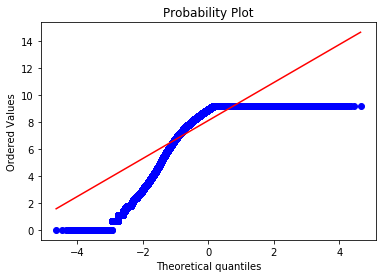

In [37]:
from scipy import stats
import pylab

stats.probplot(train.lnWeekly_Sales, dist="norm", plot=pylab )
pylab.show()

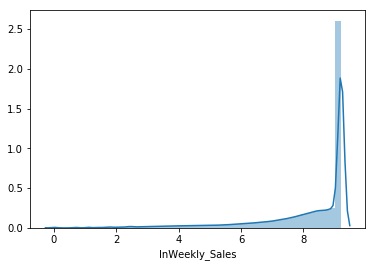

In [38]:
sns.distplot(train.lnWeekly_Sales)

In [ ]:
#train_corr=pd.DataFrame(train.corr())
#sns.heatmap(train.corr())

In [39]:
#### train X= Exery thing except Weekly_Sales
train_X=train.drop(['lnWeekly_Sales' , 'Weekly_Sales','Date'], axis=1)

#### train Y= Only Weekly_Sales 
train_y=train['lnWeekly_Sales'] 

#### Test_X
test_X=test.drop('Date',axis=1).copy()

train_X.shape, train_y.shape, test_X.shape

((420212, 15), (420212,), (115064, 15))

## Checking the accuracy and fitting linear regressor

In [41]:
import statsmodels.api as sm

In [45]:
clf = LinearRegression()

clf.fit(train_X, train_y)

y_pred_linear = clf.predict(test_X)

acc_linear = round( clf.score(train_X, train_y) * 100, 2)

print ('scorbe:'+str(acc_linear) + ' percent')

scorbe:9.71 percent


In [42]:
lm = sm.OLS(train_y,train_X).fit()

In [44]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:         lnWeekly_Sales   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     3475.
Date:                Fri, 15 May 2020   Prob (F-statistic):               0.00
Time:                        08:30:55   Log-Likelihood:            -7.9161e+05
No. Observations:              420212   AIC:                         1.583e+06
Df Residuals:                  420198   BIC:                         1.583e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Store             -0.0119      0.000    -59.

## Now checking the accuracy with Random Forest Regressor

In [46]:
from sklearn.ensemble import RandomForestRegressor

In [47]:
clf = RandomForestRegressor(n_estimators = 100)

clf.fit(train_X, train_y)

y_pred_rf = clf.predict(test_X)

acc_rf = round(clf.score(train_X, train_y) * 100, 2)

print ("Accuracy: %i %% \n"%acc_rf)

Accuracy: 99 % 



## Predicting on the basis of Random Forest model

In [53]:
prediction = pd.DataFrame({
        "Store": test.Store.astype(str),
        "Dept": test.Dept.astype(str),
        "Date": test.Date.astype(str),
        "Weekly_Sales": y_pred_rf})

In [54]:
prediction

,Store,Dept,Date,Weekly_Sales
0,1,1,2012-11-02,9.210440
1,1,2,2012-11-02,9.210440
2,1,3,2012-11-02,9.182319
3,1,4,2012-11-02,9.210440
4,1,5,2012-11-02,9.209060
5,1,6,2012-11-02,8.264805
6,1,7,2012-11-02,9.210440
7,1,8,2012-11-02,9.210440
8,1,9,2012-11-02,9.208293
9,1,10,2012-11-02,9.209176
